# Assignment 3
#### Alan Kessler, Predict 410 Section 57

This notebook contains the code accompanying the report. The original code and instructions for the assignment were set up as a tutorial. As I made modifications to that, I just created a new notebook. The code is a mix of my own the code provided for the assignment.

## Assignment Instructions

This assignment is a tutorial so have a bit of fun with it. If you would like to explore some additional options give it a try. Goal is to provide some meaningful info to the restaurant owner.

**Notes**

Both PCA and FA provide useful summary info for multivariate data, but all of the original variables are needed for their calculation, so the big question is can we use them to find a subset of variables to predict overall score? Also,trying to give meaningful labels to components is really hard. When the variables are on different scales you need to work with the correlation matrix.  For this assignment they are on same scale so we will work with the raw data. PCA only helps if the original variables are correlated, if they are independent PCA will not help.

Approach takes two steps
* First step find the dimensionality of the data, that is the number of original variables to be retained
* Second step find which ones, more on this below

## Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, FactorAnalysis
import statsmodels.formula.api as smf
import statsmodels.formula.api as sm
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

# To get balance of size correctly
plt.rcParams['figure.dpi'] = 100

In [2]:
#Read in the restaurant dataset
food_df = pd.read_csv('FACTOR1.csv')

In [3]:
# Assignmnet sets variables to lower case
food_df.columns = [s.lower() for s in food_df.columns]

## Additional Directions

Use the correlation matrix to help provide advice to the restaurant owner to try to raise the overall rating.

Look at several different models and compare them. Which model do you think is best and why?

* Model 1 Full regression model
* Model 2 Select my reduced regression model taste, wait and location
* Model 3 Full PCA model
* Model 4 Reduced PCA model with parking, taste and clean
* Model 5 FA model

Use the following steps:

* First find the PCA
* Second find the FA
* Run the models
* Compare the models and show VIF for each model


## Correlation

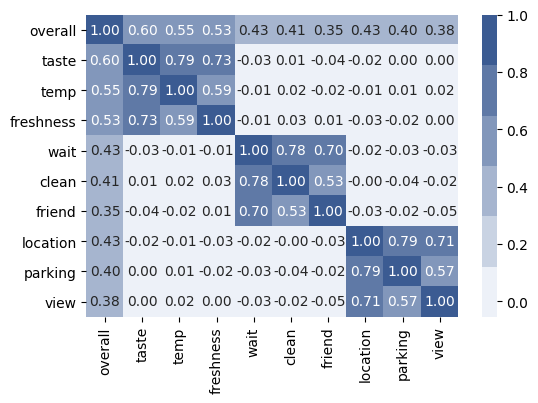

In [4]:
cdata = food_df.loc[:,['overall','taste','temp','freshness','wait','clean','friend','location','parking','view']] 
corr = cdata.corr()
ax = sns.heatmap(corr, annot=corr, fmt=".02f",
                 cmap=sns.light_palette(sns.xkcd_rgb["denim blue"]),
                 xticklabels=corr.columns, yticklabels=corr.columns)
plt.show()

## Principal Component Analysis

The correlation plot clearly shows three groups that might show up as principal components.

In [5]:
pca_data = food_df.loc[:,['taste','temp','freshness','wait','clean','friend','location','parking','view']] 
pca = PCA()
P = pca.fit(pca_data)
 
# Show portion of variance explained
print('Proportion of variance explained:', pca.explained_variance_ratio_)

Proportion of variance explained: [0.27051531 0.26603802 0.24572407 0.06231153 0.05578657 0.05420122
 0.01592382 0.01532158 0.01417787]


In [6]:
# Note that principal components analysis corresponds
# to finding eigenvalues and eigenvectors of the pca_data
pca_data_cormat = np.corrcoef(pca_data.T)
eigenvalues, eigenvectors = np.linalg.eig(pca_data_cormat)
np.around([eigenvalues], decimals=3)

array([[2.282, 2.414, 2.449, 0.484, 0.429, 0.412, 0.165, 0.175, 0.189]])

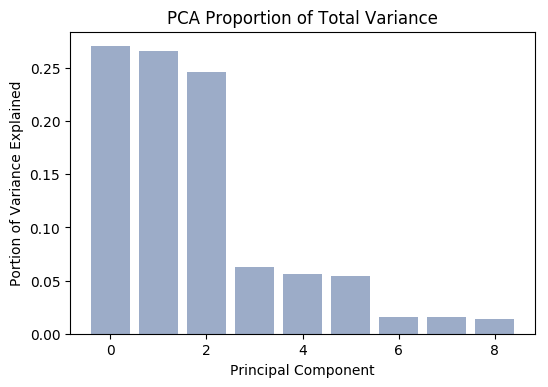

In [7]:
# Show the plot for the pricipal component analysis
plt.bar(np.arange(len(pca.explained_variance_ratio_)), 
        pca.explained_variance_ratio_, 
        color = sns.xkcd_rgb["denim blue"], 
        alpha = 0.5, align = 'center')
plt.title('PCA Proportion of Total Variance')
plt.xlabel('Principal Component')
plt.ylabel('Portion of Variance Explained')
plt.show()

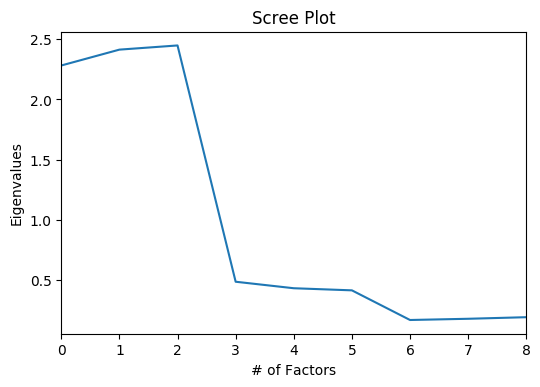

In [8]:
# From assignment tutuorial
# Show a scree plot 

d = {'eigenvalues': eigenvalues }
df1 = pd.DataFrame(data=d)
df2 = pd.Series([1,2,3,4,5,6,7,8,9])
result = pd.concat([df1, df2], 
                   axis=1, 
                   join_axes=[df2.index])

def scat(dataframe,var1,var2):
    dataframe[var2].plot()     
    plt.title('Scree Plot')
    plt.xlabel('# of Factors')
    plt.ylabel('Eigenvalues')
    
scat(result,'0','eigenvalues')
plt.show()

Plots show that first three terms explain most of the variance.

In [9]:
# Provide full formatted listing of loadings for first three components
pca_loadings = pca.components_.T

np.set_printoptions(precision = 3, 
                    suppress = True,
                    formatter={'float': '{: 0.3f}'.format})

print(pca_loadings[:,0:3])  

[[-0.475 -0.033  0.003]
 [-0.595 -0.042 -0.012]
 [-0.645 -0.022 -0.013]
 [-0.003  0.284 -0.384]
 [-0.032  0.356 -0.489]
 [-0.001  0.389 -0.505]
 [ 0.038 -0.379 -0.296]
 [ 0.033 -0.456 -0.341]
 [ 0.023 -0.535 -0.393]]


The loadings show that the groups are not strickly corresponding to the three groups.

In [10]:
# Compute full set of principal components (scores)
C = pca.transform(pca_data)
for i in range(0,9):
    name = "pca" + str(1 + i)
    food_df[name] = C[:,i]

In [11]:
# Check that the first 
pca_scores = food_df.loc[:,['pca1','pca2', 'pca3']]
pca_model_cormat = np.corrcoef(pca_scores.as_matrix().transpose()).round(decimals=3)

print(pca_model_cormat)

[[ 1.000  0.000 -0.000]
 [ 0.000  1.000 -0.000]
 [-0.000 -0.000  1.000]]


The result shows that the principal components are uncorrelated.

## Factor Analysis (Unrotated)

Uses three factors in the hope that they represent the three correlation groups.

In [12]:
# The number of iterations in assignment code makes this take a while
fa = FactorAnalysis(n_components = 3, tol=1e-8, max_iter=1000000)  
fa.fit(food_df.loc[:,['taste','temp','freshness','wait','clean','friend','location','parking','view']])

# Print factor loadings
fa_loadings = fa.components_.T
print(fa_loadings)

[[-0.028  0.028 -1.050]
 [-0.011  0.025 -1.106]
 [-0.015  0.053 -1.091]
 [ 1.037 -0.001 -0.000]
 [ 1.070 -0.018 -0.043]
 [ 1.009  0.017  0.029]
 [-0.022 -1.055 -0.007]
 [-0.038 -1.047 -0.031]
 [-0.040 -1.060 -0.034]]


In [13]:
# Compute full set of factor scores
F = fa.transform(pca_data)
for i in range(0,3):
    name = "fa_unrotated" + str(1 + i)
    food_df[name] = F[:,i]

## Factor Analysis (Varimax Rotated)

The facotr loadings show that the unrotated factors match the correlation groupings but it is good to check the correlation between the factors and the underlying data.

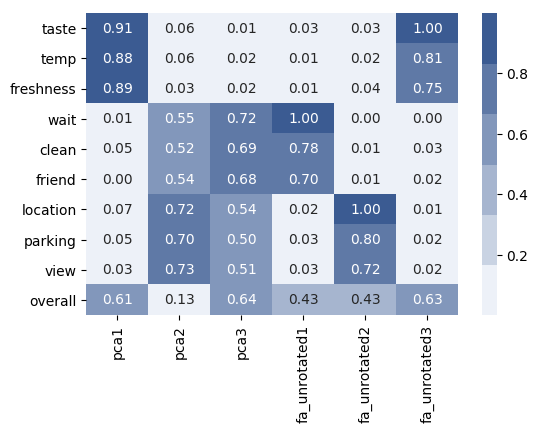

In [14]:
corr = np.absolute(food_df.corr())
corr.drop(['index', 'taste', 'temp', 'freshness', 
           'wait', 'clean', 'friend', 'location', 
           'parking', 'view', 'pca4', 'pca5', 
           'pca6', 'pca7', 'pca8', 'pca9',
           'overall'], axis=1, inplace=True)
corr.drop(['index', 'pca1', 'pca2', 'pca3', 'pca4', 'pca5', 
           'pca6', 'pca7', 'pca8', 'pca9', 'fa_unrotated1',
           'fa_unrotated2', 'fa_unrotated3'], 
          axis=0, inplace=True)
ax = sns.heatmap(corr, annot=corr, fmt=".02f",
                 cmap=sns.light_palette(sns.xkcd_rgb["denim blue"]),
                 xticklabels=corr.columns, yticklabels=corr.index.tolist())
plt.show()

The results show that the unrotated factors are creating more interpretable loadings than PCA. The unrotated facotrs are also perfectly correlated with one variable for each group. To add on to the assignment, I am going to incorporate varimax rotation to determine if I can get factors that are more correlated with the underlying variables. The code to create the factor analysis object is from the module documentation's [examples](https://github.com/bmcmenamin/fa_kit/blob/master/examples/Tutorial_Episode1.ipynb).

In [15]:
# I added the import here because it conflicts with sklearn
from fa_kit import FactorAnalysis

def run_pipeline(data, noise_cov=None, num_to_keep=3, **kwargs):

    fa = FactorAnalysis.load_data_samples(
        data,
        preproc_demean=True,
        preproc_scale=True,
        **kwargs
        )

    if noise_cov is not None:
        fa.add_noise_cov(noise_cov)
    
    fa.extract_components()

    fa.find_comps_to_retain(
        'top_n',
        num_keep=num_to_keep,
        **kwargs
        )

    fa.reextract_using_paf()

    fa.rotate_components(
        method='varimax'
        )

    return fa

In [16]:
# Generate the factors
fa_1 = run_pipeline(food_df.loc[:,['taste','temp','freshness',
                                   'wait','clean','friend',
                                   'location','parking',
                                   'view']].astype(float),
                    num_to_keep=3)

In [17]:
# Factor loadings when rotated
fa_1.comps['rot']

array([[-0.001,  0.618, -0.010],
       [ 0.007,  0.568,  0.002],
       [-0.009,  0.543,  0.011],
       [ 0.003, -0.008,  0.628],
       [ 0.005,  0.019,  0.569],
       [-0.009, -0.012,  0.530],
       [ 0.622, -0.011,  0.009],
       [ 0.571,  0.002, -0.004],
       [ 0.536,  0.012, -0.007]])

In [18]:
# Wrote a modified version of the get_component_scores function in the module
def fa_scores(row, fa=fa_1, component=0):
    """Score the data"""
    
    # Input is the row as an array
    input_data = row[['taste','temp','freshness',
                      'wait','clean','friend',
                      'location','parking','view']].values
    
    # Assume there is preprocessing
    shifted = input_data - fa.params_data['input_mean']
    scaled = shifted / fa.params_data['input_scale']
    
    # Generate the factors
    factors = scaled.dot(fa.comps['rot'])[0]
    return factors[component]

food_df['fa_rotated1'] = food_df.apply(fa_scores, axis=1, args=(fa_1, 0))
food_df['fa_rotated2'] = food_df.apply(fa_scores, axis=1, args=(fa_1, 1))
food_df['fa_rotated3'] = food_df.apply(fa_scores, axis=1, args=(fa_1, 2))

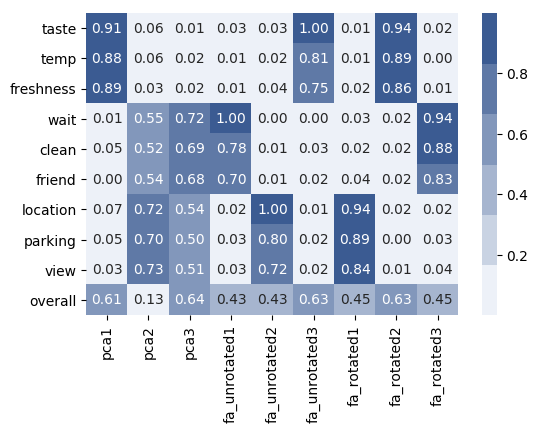

In [19]:
# Test the correlation again
corr = np.absolute(food_df.corr())
corr.drop(['index', 'taste', 'temp', 'freshness', 
           'wait', 'clean', 'friend', 'location', 
           'parking', 'view', 'pca4', 'pca5', 
           'pca6', 'pca7', 'pca8', 'pca9',
           'overall'], axis=1, inplace=True)
corr.drop(['index', 'pca1', 'pca2', 'pca3', 'pca4', 'pca5', 
           'pca6', 'pca7', 'pca8', 'pca9', 'fa_unrotated1',
           'fa_unrotated2', 'fa_unrotated3', 'fa_rotated1',
           'fa_rotated2', 'fa_rotated3'], 
          axis=0, inplace=True)
ax = sns.heatmap(corr, annot=corr, fmt=".02f",
                 cmap=sns.light_palette(sns.xkcd_rgb["denim blue"]),
                 xticklabels=corr.columns, yticklabels=corr.index.tolist())
plt.show()

The resulting rotation creates a much stronger interpretation than PCA.

## Models to Build

From the assignment, I need to build:

* Model 1 Full regression model
* Model 2 Select my reduced regression model taste, wait and location
* Model 3 Full PCA model
* Model 4 Reduced PCA model with parking, taste and clean
* Model 5 FA model (unrotated)

I will also build Model 6 using the three rotated factors.

In [20]:
model1 = smf.ols(formula = "overall~taste+temp+freshness+wait+clean+friend+location+parking+view", 
                 data = food_df).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                overall   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     507.9
Date:                Sat, 17 Feb 2018   Prob (F-statistic):               0.00
Time:                        08:18:38   Log-Likelihood:                -179.96
No. Observations:                1000   AIC:                             379.9
Df Residuals:                     990   BIC:                             429.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0745      0.094      0.789      0.430      -0.111       0.260
taste          0.2249      0.017     13.447      0.000       0.192       0.258
temp           0.0788      0.011      7.248      0.000       0.057       0.100
freshness      0.0899      0.009      9.841      0.000       0.072       0.108
wait           0.1706      0.017     10.178      0.000       0.138       0.203
clean          0.0660      0.011      6.140      0.000       0.045       0.087
friend         0.0625      0.009      7.000      0.000       0.045       0.080
location       0.1552      0.017      9.246      0.000       0.122       0.188
parking        0.0797      0.011      6.935      0.000       0.057       0.102
view           0.0597      0.009      6.731      0.000       0.042       0.077
==============================================================================
Omnibus:                      597.724   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.310
Skew:                          -0.001   Prob(JB):                     3.59e-13
Kurtosis:                       1.827   Cond. No.                         196.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
model2 = smf.ols(formula = "overall~taste+wait+location", 
                 data = food_df).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                overall   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     1052.
Date:                Sat, 17 Feb 2018   Prob (F-statistic):          3.27e-308
Time:                        08:18:38   Log-Likelihood:                -328.95
No. Observations:                1000   AIC:                             665.9
Df Residuals:                     996   BIC:                             685.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2025      0.109      1.864      0.063      -0.011       0.416
taste          0.4011      0.010     40.021      0.000       0.381       0.421
wait           0.2997      0.010     29.175      0.000       0.280       0.320
location       0.2919      0.010     28.984      0.000       0.272       0.312
==============================================================================
Omnibus:                       59.245   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.572
Skew:                           0.037   Prob(JB):                     1.25e-05
Kurtosis:                       2.268   Cond. No.                         108.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
model3 = smf.ols(formula = "overall~pca1+pca2+pca3+pca4+pca5+pca6+pca7+pca8+pca9", 
                 data = food_df).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                overall   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     507.9
Date:                Sat, 17 Feb 2018   Prob (F-statistic):               0.00
Time:                        08:18:38   Log-Likelihood:                -179.96
No. Observations:                1000   AIC:                             379.9
Df Residuals:                     990   BIC:                             429.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.1470      0.009    667.670      0.000       6.129       6.165
pca1          -0.2045      0.005    -45.251      0.000      -0.213      -0.196
pca2          -0.0437      0.005     -9.591      0.000      -0.053      -0.035
pca3          -0.2274      0.005    -47.968      0.000      -0.237      -0.218
pca4          -0.0019      0.009     -0.205      0.838      -0.020       0.017
pca5          -0.0441      0.010     -4.435      0.000      -0.064      -0.025
pca6           0.0275      0.010      2.729      0.006       0.008       0.047
pca7          -0.0447      0.019     -2.398      0.017      -0.081      -0.008
pca8          -0.1574      0.019     -8.287      0.000      -0.195      -0.120
pca9          -0.1066      0.020     -5.399      0.000      -0.145      -0.068
==============================================================================
Omnibus:                      597.724   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.310
Skew:                          -0.001   Prob(JB):                     3.59e-13
Kurtosis:                       1.827   Cond. No.                         4.37
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
model4 = smf.ols(formula = "overall~pca1+pca2+pca3", 
                 data = food_df).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                overall   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     1315.
Date:                Sat, 17 Feb 2018   Prob (F-statistic):               0.00
Time:                        08:18:38   Log-Likelihood:                -241.98
No. Observations:                1000   AIC:                             492.0
Df Residuals:                     996   BIC:                             511.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.1470      0.010    629.417      0.000       6.128       6.166
pca1          -0.2045      0.005    -42.659      0.000      -0.214      -0.195
pca2          -0.0437      0.005     -9.042      0.000      -0.053      -0.034
pca3          -0.2274      0.005    -45.220      0.000      -0.237      -0.218
==============================================================================
Omnibus:                       93.319   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.713
Skew:                          -0.012   Prob(JB):                     5.82e-07
Kurtosis:                       2.170   Cond. No.                         2.04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
model5 = smf.ols(formula = "overall~fa_unrotated1+fa_unrotated2+fa_unrotated3", 
                 data = food_df).fit()
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                overall   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     1107.
Date:                Sat, 17 Feb 2018   Prob (F-statistic):          1.53e-316
Time:                        08:18:38   Log-Likelihood:                -309.69
No. Observations:                1000   AIC:                             627.4
Df Residuals:                     996   BIC:                             647.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         6.1470      0.010    588.213      0.000       6.126       6.168
fa_unrotated1     0.2933      0.010     28.065      0.000       0.273       0.314
fa_unrotated2    -0.2996      0.010    -28.579      0.000      -0.320      -0.279
fa_unrotated3    -0.4377      0.011    -41.425      0.000      -0.458      -0.417
==============================================================================
Omnibus:                       74.401   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.628
Skew:                           0.036   Prob(JB):                     2.72e-06
Kurtosis:                       2.219   Cond. No.                         1.01
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
model6 = smf.ols(formula = "overall~fa_rotated1+fa_rotated2+fa_rotated3", 
                 data = food_df).fit()
model6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                overall   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     1480.
Date:                Sat, 17 Feb 2018   Prob (F-statistic):               0.00
Time:                        08:18:38   Log-Likelihood:                -194.51
No. Observations:                1000   AIC:                             397.0
Df Residuals:                     996   BIC:                             416.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       6.1470      0.009    660.015      0.000       6.129       6.165
fa_rotated1     0.2085      0.006     34.568      0.000       0.197       0.220
fa_rotated2     0.2796      0.006     46.618      0.000       0.268       0.291
fa_rotated3     0.2094      0.006     34.423      0.000       0.197       0.221
==============================================================================
Omnibus:                      313.049   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.778
Skew:                           0.000   Prob(JB):                     4.22e-11
Kurtosis:                       1.929   Cond. No.                         1.56
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Variance Inflation Factors

Calculate the variance inflation factors for each model created using code provided by the assignment and then modified slightly.

In [26]:
y, X = dmatrices("overall ~ taste+temp+freshness+wait+clean+friend+location+parking+view", 
                 data=food_df, return_type="dataframe")

vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print('\n ----- VIF for Model 1 ----- \n')
print(vif)


 ----- VIF for Model 1 ----- 

[105.31057172729297, 3.7339305023025977, 2.666947996579804, 2.155696222950924, 3.5665022511678393, 2.5722838192097766, 1.9647506059999649, 3.723110119062428, 2.7064357263205463, 2.046687628686199]


In [27]:
y, X = dmatrices("overall ~ taste+wait+location", 
                 data=food_df, return_type="dataframe")

vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print('\n ----- VIF for Model 2 ----- \n')
print(vif)


 ----- VIF for Model 2 ----- 

[104.04412778717976, 1.001059279040755, 1.0011179362680949, 1.0007775584240306]


In [28]:
y, X = dmatrices("overall ~ pca1+pca2+pca3+pca4+pca5+pca6+pca7+pca8+pca9", 
                 data=food_df, return_type="dataframe")

vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print('\n ----- VIF for Model 3 ----- \n')
print(vif)


 ----- VIF for Model 3 ----- 

[0.9999999999999998, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998, 0.9999999999999998, 1.0, 0.9999999999999998, 1.0000000000000002, 0.9999999999999998]


In [29]:
y, X = dmatrices("overall ~ pca1+pca2+pca3", 
                 data=food_df, return_type="dataframe")

vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print('\n ----- VIF for Model 4 ----- \n')
print(vif)


 ----- VIF for Model 4 ----- 

[1.0, 1.0, 0.9999999999999998, 1.0]


In [30]:
y, X = dmatrices("overall ~ fa_unrotated1+fa_unrotated2+fa_unrotated3", 
                 data=food_df, return_type="dataframe")

vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print('\n ----- VIF for Model 5 ----- \n')
print(vif)


 ----- VIF for Model 5 ----- 

[0.9999999999999998, 1.0, 1.0, 1.0]


In [31]:
y, X = dmatrices("overall ~ fa_rotated1+fa_rotated2+fa_rotated3", 
                 data=food_df, return_type="dataframe")

vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print('\n ----- VIF for Model 6 ----- \n')
print(vif)


 ----- VIF for Model 6 ----- 

[0.9999999999999998, 1.0011572712036259, 1.0000710255243446, 1.0011631068191633]


## Final Instructions

Which model do you like best and why?

For the full regression model sum the coefficients for each three variable groupings
* Group 1: taste, temp freshness 
* Group 2: wait, clean, friend 
* Group 3: location, parking, view 

How do you interpret this info? Compare with the choice model (assuming the assignment is referring to model 2).

In [32]:
group1 = .2249+.0788+.0899
print("Group 1: {:.4f}".format(group1))
group2 = .1706+.066+.0625
print("Group 2: {:.4f}".format(group2))
group3 = .1552+.0797+.0597
print("Group 3: {:.4f}".format(group3))

Group 1: 0.3936
Group 2: 0.2991
Group 3: 0.2946


The sums are very close to the coefficients of Model 2. I would interpret that as further evidence that taste, wait, and location are picking up almost all of the information captured by the other survey variables.

For understanding how the individual variables make up the overall score, Model 1 is preferred. For discussing the importance of a category of variables, the rotated factor analysis used in Model 6 is my preference. 

## Additional Information for Proposal

The analysis above suggests which category is most important to getting a high overall score. It is also interesting to look at which categories for which there is room to improve. The combination of these two pieces of information are used in the final proposal found in the report.

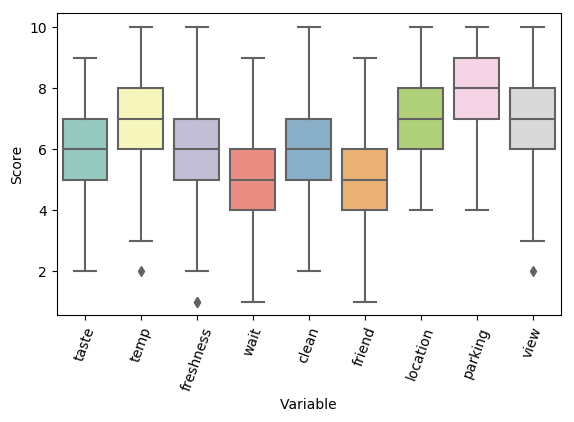

In [33]:
# Box plot of survey results
df = pd.melt(food_df[['taste','temp','freshness',
                     'wait','clean','friend',
                     'location','parking','view']])

plt.figure(figsize=(6.5, 4))
ax = sns.boxplot(x='variable', y='value', 
                 data=df, palette='Set3')
ax.set(ylabel='Score', xlabel='Variable')
plt.xticks(rotation=70)
plt.show()